## Optimal control
Consider a discrete linear time-invariant (LTI) dynamical system
$$\dot x(t) = Ax(t) + Bu(t),$$
where 
$x(t)$ and $u(t)$ are the system's state and control vectors at time $t$

**Optimal control task:** Compute $u(t)$ which drives the system state somewhere while optimising a prescribed measure of performace and satisfying some requirements\constraints. 

Real-life examples (they are everywhere):
1) Control a drone to hover/fly without crashing
2) Maintain optimal chemicals concentration in a chemical reactor
3) Boost/throttle CPU frequencies under load subject to temperature constraints
4) Regulate voltage/current in a battery charger
5) etc..

### Practical example
Consider a cart pole with inverted pendulum linearised around the unstable equlibrium (upward position), i.e., segway scooter.

State vector $x$ is
$$x = [position, velocity, angle, angular\ velocity]^T$$

Input vector $u$ is the force applied to the cart-pole.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg

Linearised model for the cart pole is as follows

In [2]:
M = 1           #cart pole mass
m = 0.1         #pendulum mass
l = 1           #pendulum length
g = 9.8         #gravity

A = np.array([[0, 1, 0,            0],
              [0, 0, -m*g/M,       0],
              [0, 0, 0,            1],
              [0, 0, (m+M)*g/l/M, 0]])
B = np.array([[0],
             [1/M],
             [0],
             [-1/l/M]]);

In [3]:
def xdot(x,u):
    return np.dot(A,x)+np.dot(B,u)

In [4]:
def integrateOpenLoop(x0, U, steps, dt=1e-3):
    X = np.empty([x0.size, steps+1])
    X[:,0]=x0
    for t in range(steps):
        x = X[:, t]               #current state
        u = U[:, t]               #current control
        xnext = x + xdot(x,u)*dt  #Euler integrator
        X[:, t+1] = xnext
    return X

In [5]:
# integrate dynamics with 0 control input
dt = 1e-3
steps = 1000
x0 = np.array([0,0,1e-3,0])
U = np.zeros([1, steps])
X=integrateOpenLoop(x0,U, steps, dt)

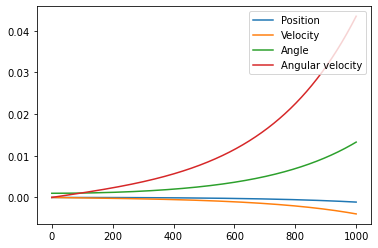

In [6]:
legend = ["Position", "Velocity", "Angle", "Angular velocity"]
for n in range(X.shape[0]):
    plt.plot(X[n,:],label="%s"%legend[n])
plt.legend(loc=1)

States deviate exponetionally from origin, so let's stabialise it by prescribing a cost associated with states' deviation from the unstable equlibrium (plus let's penalise control)

$$\min_{x,u} \int_{t=0}^{\infty}q(x(t),u(t)) dt $$
$$subject\ to\ \dot x(t)=Ax(t)+Bu(t)$$

**Example:** $q(x,u)=\| x\|_{*}^2 + \|u\|_{**}^2$, where $\|\cdot\|_*$ and $\|\cdot\|_{**}$ are vector norms that we can choose (design parameter), e.g., weighted 2-norms $\| x\|_{Q}^2=x^TQx$ and $\|u\|_{R}^2 = u^TRu $ for some matrices $Q\succ0$ and $R\succ0$.


**Note:** We can also use cost functions which have direct physical meaning and often related to performace/efficience/operating costs/etc, thus known under the name of Economic Model Predictive Control.

In [7]:
Q = np.diag([1, 100, 0.1, 1])
R = 0.001*np.eye(1)

Right now open loop system is unstable and the stage cost
$$q(x,u) = \| x_t\|_{Q}^2 + \|u_t\|_{R}^2$$
is increasing with time. We will see it right now.

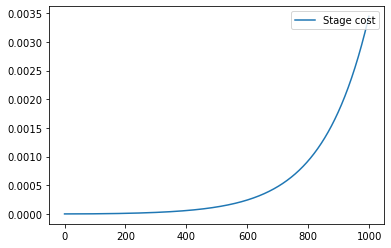

In [8]:
q = np.empty(steps)
for t in range(steps):
    x = X[:, t]
    u = U[:, t]
    q[t] = np.dot(x, np.dot(Q, x)) + np.dot(u, np.dot(R, u))
plt.plot(q, label="Stage cost")
plt.legend(loc=1)

### Linear-Quadratic Regulator
Problem 
$$\min_{x(t),u(t)} \int_{t=0}^{\infty} (\| x(t)\|_{Q}^2 + \|u(t)\|_{R}^2)dt $$
$$subject\ to\ \dot x(t)=Ax(t)+Bu(t)$$
has an analytical solution known as LQR in the form of $u(x) = -Kx$. One can compute it by solving Algebraic Riccati equation 

$$A^{T}P+PA-PBR^{-1}B^{T}P+Q=0$$
and 
$$K=R^{-1}B^{T}P$$

In [9]:
P=scipy.linalg.solve_continuous_are(A, B, Q, R)
K=np.matmul(np.linalg.inv(R),np.matmul(B.T,P))

In [10]:
def integrateClosedLoop(x0, K, steps, dt=1e-3):
    X = np.empty([x0.size, steps+1])
    U = np.empty([K.shape[0], steps])
    X[:,0]=x0
    for t in range(steps):
        x = X[:, t]               #current state
        u = -np.matmul(K,x)       #current control
        xnext = x + xdot(x,u)*dt  #Euler integrator
        X[:, t+1] = xnext
        U[:, t] = u
    return X, U

In [11]:
x0 = np.array([0.1,0,-1e-3,0])
steps=10000
X,U=integrateClosedLoop(x0,K, steps, dt)

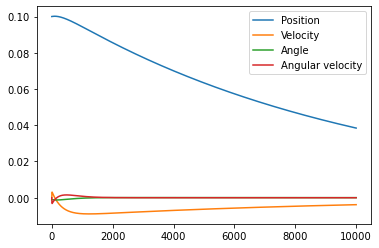

In [12]:
legend = ["Position", "Velocity", "Angle", "Angular velocity"]
for n in range(X.shape[0]):
    plt.plot(X[n,0:],label="%s"%legend[n])
plt.legend(loc=1)

### Asymptotic stability

The states and control vectors are converging to zero - is system asymptotically stable? How do we know that? Let's consider the evolution of the stage cost

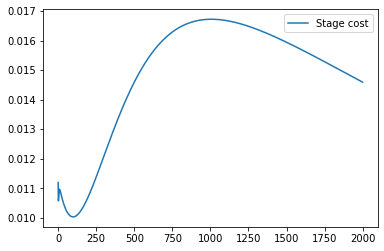

In [13]:
q = np.empty(steps)
for t in range(steps):
    x = X[:, t]
    u = U[:, t]
    q[t] = np.dot(x, np.dot(Q, x)) + np.dot(u, np.dot(R, u))
plt.plot(q[0:2000], label="Stage cost")
plt.legend(loc=1)

For time steps from 100 to 1000 the stage cost is increasing. Need a better way to quantify stability point-wise. 

Total cost associated with LQR is a quadratic function (with $P\succ0$) 
$$x^TPx$$ called Value funtion (or Cost-to-go).

1) It is strictly positive everywhere except the origin (where is is zero), and 
2) It has a negative time derivative except the origin (where is is zero), so it is strictly decreasing in time.

A function $V(x(t))$  that has these properties is called a Lyapunov function. Existence of such a funtion proves that system is stable in the sense of Lyapunov.

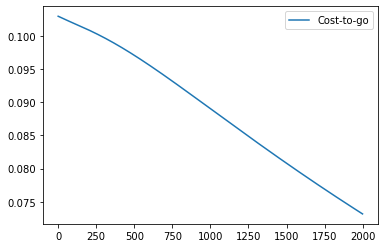

In [14]:
p = np.empty(steps)
for t in range(steps):
    x = X[:, t]
    p[t] = np.dot(x, np.dot(P, x))
plt.plot(p[0:2000], label="Cost-to-go")
plt.legend(loc=1)

### Beyond LQR

Motivation to go futher:
1) LQR assumes that $u$ is not limited and can take arbitrary values. What is we have a limited control athority? 
2) LQR requires linear dynamics and quadratic stage cost. What if we have a nonlinear system? Or we care about different cost functions?
3) Explicit state constraints due to safety considerations?
4) External disturbances? Uncertainty in dynamics? 

**MPC** - Model Predictive Control - is a set of tools for constructing, solving and analysing numerical optimisation based control tasks (and resulting control laws)

MPC Recipe:

1) Optimal control problem has to be discretised to use numerical solvers.
2) Infinite time horizon replaced with a finite prediction horizon.
3) Optimal control law is now replaced with point-wise function evaluation at each time step.

Research questions:

1) How to ensure stability of the closed loop system by design?
2) What are the consequences of finite prediction horizon on optimality?
3) How to account for disturbances and uncertainies?
4) Structure exploiting algorithms?

### Model predictive control

Transform
$$\min_{x(t),u(t)} \int_{t=0}^{\infty} (\| x(t)\|_{Q}^2 + \|u(t)\|_{R}^2)dt $$
$$subject\ to\ \dot x(t)=Ax(t)+Bu(t)$$
into
$$\min_{x_k,u_k} \sum_{k=0}^{N} (\| x_k\|_{Q}^2 + \|u_k\|_{R}^2)\Delta t + q_f(x_N)$$
$$subject\ to\ x_{k+1}=A_d x_k+B_d u_k,\ x_0 = x_{init}$$
assuming that $N$ is big enough to capture "interesting" parts and $q_f(x_N)$ is the terminal cost which accounts for the tail.



For now let's use due to simpicity
$$q_f(\cdot)\equiv0$$

In [15]:
#discretize the system so x_next = Ad * x + Bd * u
dim_x = 4
dim_u = 1
Ad= np.eye(dim_x)+ A*dt
Bd = B*dt
Qd=Q*dt
Rd=R*dt

In [16]:
from cvxpy import *

In [17]:
N=100
U = Variable((dim_u, N))
X = Variable((dim_x, N+1))
x_init = Parameter(dim_x)
objective = 0
constraints = [X[:,0] == x_init]
for k in range(N):
    objective += quad_form(X[:,k], Qd) + quad_form(U[:,k], Rd)
    constraints += [X[:,k+1] == Ad@X[:,k] + Bd@U[:,k]]
mpc = Problem(Minimize(objective), constraints)    

In [18]:
%%time
x0 = np.array([1,0,-1e-3,0])
steps = 1000
Xtraj = np.empty([x0.size, steps])
Jtraj = np.empty(steps)
x=x0
for t in range(steps):
    x_init.value = x
    Jtraj[t]=mpc.solve(solver=OSQP, warm_start=True)
    Xtraj[:,t] = x;
    x = Ad.dot(x) + Bd.dot(U[:,0].value)

CPU times: total: 18.7 s
Wall time: 18.8 s


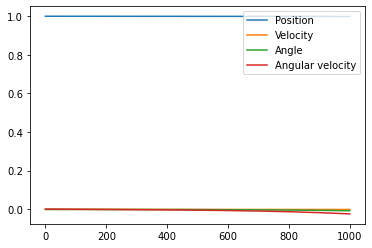

In [19]:
legend = ["Position", "Velocity", "Angle", "Angular velocity"]
for n in range(Xtraj.shape[0]):
    plt.plot(Xtraj[n,:],label="%s"%legend[n])
plt.legend(loc=1)

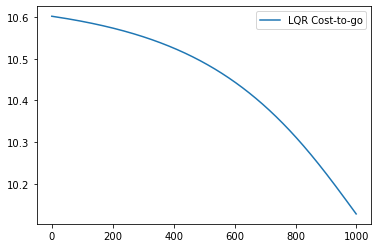

In [20]:
p = np.empty(steps)
for k in range(steps):
    x = Xtraj[:, k]
    p[k] = np.dot(x, np.dot(P, x))
plt.plot(p, label="LQR Cost-to-go")
plt.legend(loc=1)

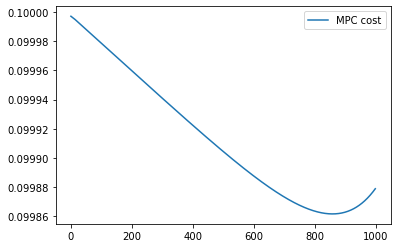

In [21]:
plt.plot(Jtraj, label="MPC cost")
plt.legend(loc=1)

**Lesson learned? Using $q_f(\cdot)\equiv 0$ does not look like a good choice here.** First we need to understand why it might be not a good choice and when it is. Next we will figure out if we can do better. 

Stage cost usually represent a short term goals, e.g., minimise control efforts, while the integral over the sufficiently long time horizon encodes the control task. 

**If $N$ is too small** or **$q_f(\cdot)$ in not big enough** the controller is underestimating long-term costs and is "too lazy" to capture and complete the task.

What we can do?

1) Increase N? One can prove that (under a set of assumtions) there exists a critical value for $N$ such that the closed loop is stable.
2) Place terminal cost which **does not underestimate** the total cost associated with the tail.
2) Use LQR cost? Yes, but we need to constrain the terminal state to stay in the set where LQR control is a suitable choice. 
3) Explictly ask for the last state to be at the origin. It is equivalent to placing infinite terminal cost (everywhere except the origin).


Now let's add LQR cost-to-go as the terminal cost

In [22]:
N=100
U = Variable((dim_u, N))
X = Variable((dim_x, N+1))
x_init = Parameter(dim_x)
objective = 0
constraints = [X[:,0] == x_init]
for k in range(N):
    objective += quad_form(X[:,k], Qd) + quad_form(U[:,k], Rd)
    constraints += [X[:,k+1] == Ad@X[:,k] + Bd@U[:,k]]
objective+=quad_form(X[:,N], P)
mpc = Problem(Minimize(objective), constraints)    

In [23]:
%%time
x0 = np.array([1,0,-1e-3,0])
steps = 1000
Xtraj = np.empty([x0.size, steps])
Utraj = np.empty(steps)
Jtraj = np.empty(steps)
x=x0
for t in range(steps):
    Xtraj[:,t] = x;
    x_init.value = x
    Jtraj[t]=mpc.solve(solver=OSQP, warm_start=False)
    x = Ad.dot(x) + Bd.dot(U[:,0].value)
    Utraj[t] = U[:,0].value;

CPU times: total: 20.6 s
Wall time: 20.8 s


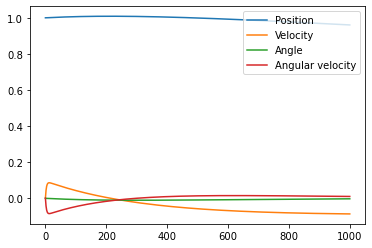

In [24]:
legend = ["Position", "Velocity", "Angle", "Angular velocity"]
for n in range(Xtraj.shape[0]):
    plt.plot(Xtraj[n,0:],label="%s"%legend[n])
plt.legend(loc=1)

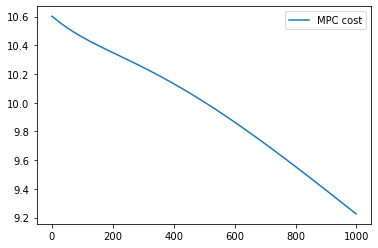

In [25]:
plt.plot(Jtraj, label="MPC cost")
plt.legend(loc=1)

### Input constraints

Now we explore one of the main advantages of MPC - its natural ability to handle constraints. Lets first have a look at the control signal from the unconstrained MPC control law

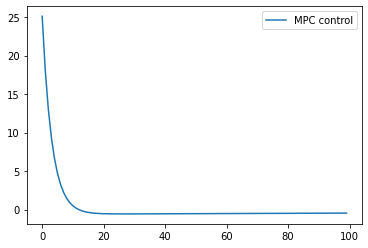

In [26]:
plt.plot(Utraj[0:100], label="MPC control")
plt.legend(loc=1)

In [27]:
N=100
U = Variable((dim_u, N))
X = Variable((dim_x, N+1))
x_init = Parameter(dim_x)
objective = 0
constraints = [X[:,0] == x_init]
for k in range(N):
    objective += quad_form(X[:,k], Qd) + quad_form(U[:,k], Rd)
    constraints += [X[:,k+1] == Ad@X[:,k] + Bd@U[:,k]]
    constraints += [U[:,k] <=2] 
    constraints += [U[:,k] >=-2]
objective+=quad_form(X[:,N], P)
mpc = Problem(Minimize(objective), constraints)    

In [28]:
%%time
x0 = np.array([1,0,-1e-3,0])
steps = 1000
Xtraj = np.empty([x0.size, steps])
Utraj = np.empty(steps)
Jtraj = np.empty(steps)
x=x0
for t in range(steps):
    x_init.value = x
    Jtraj[t]=mpc.solve(solver=MOSEK, warm_start=True)
    Xtraj[:,t] = x;
    Utraj[t] = U[:,0].value;
    x = Ad.dot(x) + Bd.dot(U[:,0].value)

CPU times: total: 1min
Wall time: 46.7 s


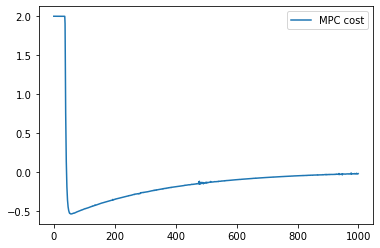

In [29]:
plt.plot(Utraj[0:], label="MPC cost")
plt.legend(loc=1)

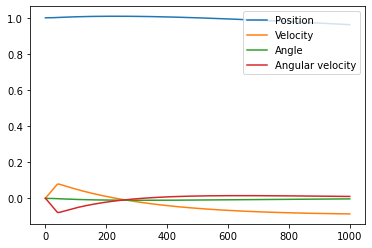

In [30]:
legend = ["Position", "Velocity", "Angle", "Angular velocity"]
for n in range(Xtraj.shape[0]):
    plt.plot(Xtraj[n,0:1000],label="%s"%legend[n])
plt.legend(loc=1)

#### Machine learning in MPC

Consider the MPC problem
$$V(x_{init})=\min_{x_k,u_k} \sum_{k=0}^{N} q(x_k,u_k) + q_f(x_N)$$
$$subject\ to\ x_{k+1}=f(x_k,u_k),\ x_0 = x_{init}$$
$$             c(x_k,u_k)\leq 0$$
It has the following ingrediets that can benefit from ML:
1) Dynamics -> Deep learning 
2) Constraints -> Safe learning 
3) Stage costs -> Active learning
4) Value function -> Reinforcement leaning
5) Optimal control law -> Function approximations